<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>Working with Satellite Data</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/MetPy/_images/sphx_glr_GINI_Water_Vapor_001.png" alt="Example Satellite Image" style="height: 500px;"></div>


## Overview:

* **Teaching:** 60 minutes
* **Exercises:** 30 minutes

### Questions
1. How can satellite data be obtained with Siphon?
2. What format is satellite data distributed in?
3. How can MetPy be used to open and explore satellite data?
4. How can maps of satellite data be made?
5. How can other datasets be integrated with satellite data?

### Objectives
1. Download satellite data with Siphon
2. Explain and read the GINI format
3. Make a plot of the data
4. Use colortables and annotations
5. Bonus: Animations

## 1. Download satellite data with Siphon

The first step is to find the satellite data. If we browse over to http://thredds.ucar.edu/thredds/, we're presented with the top-level [THREDDS Data Server (TDS)](https://www.unidata.ucar.edu/software/thredds/current/tds/TDS.html) catalog. Click on the `Satellite Data` directory. You’ll see many datasets for Water Vapor, IR, Visible, etc. For this exercise, we are going to start with Waver Vapor imagery.

Click on the `Water Vapor (6.5 / 5.7 um)` directory. We will look at the CONUS (CONtiguous US) data from the GOES East satellite, so click on the `EAST-CONUS_4km` directory. You will find an archive of about a month’s worth of imagery that is replaced on a rolling basis. Click on the ```current``` directory, it always contains the last 24 hours’ worth of data. We could download the files to our computers from here, but that can become tedious for downloading many files, requires us to store them on our computer, and does not lend itself to automation.

We can use Unidata's [Siphon](https://github.com/Unidata/siphon) package to parse the catalog from the TDS. This provides us a nice programmatic way of accessing the data. We start by importing the `TDSCatalog` class from siphon and giving it the URL to the catalog we just surfed to manually. **Note:** Instead of giving it the link to the HTML catalog, we change the extension to XML, which asks the TDS for the XML version of the catalog. This is much better to work with in code. Copy the URL of the current data directory from your browser and replace the html extension. It should look like this: `http://thredds.ucar.edu/thredds/catalog/satellite/WV/EAST-CONUS_4km/current/catalog.xml`

In [1]:
from siphon.catalog import TDSCatalog
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/satellite/WV/EAST-CONUS_4km/current/catalog.xml')

We now have a `TDSCatalog` object called `cat` that we can examine and use to get handles to work with the data. To find the latest file, we can look at the `cat.datasets` attribute. This is a Python dictionary, mapping the name of the dataset to a Python Dataset object (which came from more XML supplied by the TDS). Since this is a dictionary, we can look at a list of keys and see what datasets are available. Let’s look at the first five keys:

In [2]:
list(cat.datasets)[:5]

['EAST-CONUS_4km_WV_20170302_2000.gini',
 'EAST-CONUS_4km_WV_20170302_1945.gini',
 'EAST-CONUS_4km_WV_20170302_1930.gini',
 'EAST-CONUS_4km_WV_20170302_1915.gini',
 'EAST-CONUS_4km_WV_20170302_1900.gini']

What we really want is the most recent data, which is the first item in the list. We can pull that out, and use its name to get the actual Python `Dataset` object:

In [3]:
dataset_name = list(cat.datasets)[0]
dataset = cat.datasets[dataset_name]
print(dataset)

The `catalog.Dataset` class provides access to a lot of information about a dataset, like metadata (e.g. time range, spatial extent). What we want most however, is to know how to access the data. This is provided by the `dataset.access_urls` attribute:

In [4]:
dataset.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20170302_2000.gini',
 'HTTPServer': 'http://thredds.ucar.edu/thredds/fileServer/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20170302_2000.gini',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20170302_2000.gini',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20170302_2000.gini',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20170302_2000.gini',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20170302_2000.gini',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20170302_2000.gini',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/satellite/WV/EAST-CONUS_4km/current/EAST-CONUS_4km_WV_20170302_2000.g

These different URLs provide access to the data in different ways: some support different protocols (like [OPeNDAP]( https://www.opendap.org) or CDMRemote), others allow harvesting metadata (e.g. ISO). We're going to start simple, so we want to use the `HTTPServer` method, which allows downloading the datafile using HTTP. We can take this URL and pass it to the `urlopen` function from the `urllib.request` module in Python's standard library. This gives us a Python file-like object, which for the most part we can treat just like a file we opened locally. You could also programmatically download the file locally if you needed to archive it for research purposes.


In [5]:
from urllib.request import urlopen
remote_gini_file = urlopen(dataset.access_urls['HTTPServer'])

### Exercise: Find your own data
1. Open a web browser and pick out a [satellite dataset](http://thredds.ucar.edu/thredds/idd/satellite.html)
2. Crawl down into the dataset directory (i.e. one with a whole bunch of `.gini` files); this can be current or data from some past available data that you find interesting
3. Grab the URL and pass to `TDSCatalog`
4. Determine which data access URLs are available for your dataset.
5. Open a file reference

In [6]:
# Open the TDS catalog

# Find the dataset of interest

# Get the data access URLs for this dataset

# Open a file reference to the remote dataset

<hr style="height:2px;">

## 2. Explain and read the GINI format

Now that we have this file-like object, we could certainly `read()` data and parse it by, but that is a lot of work. The data are in the [GINI format](http://weather.unisys.com/wxp/Appendices/Formats/GINI.html), a binary format. Luckily, MetPy has built in support to read GINI files. We simply import the `GiniFile` class, and passing it a file-like object (which could be an opened local file or a remote file as we will demonstrate). There is also a nice representation with `print()` to show the basic information about the dataset.

In [7]:
from metpy.io.gini import GiniFile
gini = GiniFile(remote_gini_file)
print(gini)

GiniFile: GOES-13 East CONUS WV (6.5/6.7 micron)
	Time: 2017-03-02 20:00:19
	Size: 1280x1280
	Projection: lambert_conformal
	Lower Left Corner (Lon, Lat): (-113.1333, 16.3691)
	Resolution: 4km


`GiniFile` was able to successfully parse the data and we see (as expected) that we have a 4km CONUS water vapor image from GOES-13 East. While `GiniFile` itself provides a low-level interface to all the information in the file (which can be handy for checking to see if the file was parsed correctly), we don't need the low level details. By using the `to_dataset()` method, we can convert the data into a form that resembles the `Dataset` object from [netCDF4-python](https://unidata.github.io/netcdf4-python/).

In [8]:
gini_ds = gini.to_dataset()
print(gini_ds)

root

Dimensions:
<class 'metpy.io.cdm.Dimension'>: name = time, size = 1
<class 'metpy.io.cdm.Dimension'>: name = x, size = 1280
<class 'metpy.io.cdm.Dimension'>: name = y, size = 1280

Variables:
<class 'metpy.io.cdm.Variable'>: int32 time(time)
	units: milliseconds since 2017-03-02T00:00:00
	shape = 1
<class 'metpy.io.cdm.Variable'>: int32 Lambert_Conformal()
	grid_mapping_name: lambert_conformal_conic
	standard_parallel: 25.0
	longitude_of_central_meridian: -95.0
	latitude_of_projection_origin: 25.0
	earth_radius: 6371200.0
<class 'metpy.io.cdm.Variable'>: float64 x(x)
	units: m
	long_name: x coordinate of projection
	standard_name: projection_x_coordinate
	shape = 1280
<class 'metpy.io.cdm.Variable'>: float64 y(y)
	units: m
	long_name: y coordinate of projection
	standard_name: projection_y_coordinate
	shape = 1280
<class 'metpy.io.cdm.Variable'>: float64 lon(y, x)
	long_name: longitude
	units: degrees_east
	shape = (1280, 1280)
<class 'metpy.io.cdm.Variable'>: float64 lat(y, x)
	

Or, we can take the `gini_ds.variables` attribute, which is a dictionary, and convert it to a Python list (using `list`); this will pull all of the keys out of the dictionary and give us a clear way to see what data are in the file:

In [9]:
list(gini_ds.variables)

['time', 'Lambert_Conformal', 'x', 'y', 'lon', 'lat', 'WV']

Our goal is to plot water vapor imagery, so we're going to ask for `WV` from the `.variables` dictionary.
Rather than just giving back the raw array of data, this gives back a `Variable` object; from here not only
can we get the raw data values, but there is useful metadata as well. We can see just what additional information
is present by printing out the `Variable` object:

In [10]:
data_var = gini_ds.variables['WV']
print(data_var)

<class 'metpy.io.cdm.Variable'>: uint8 WV(y, x)
	long_name: WV (6.5/6.7 micron)
	missing_value: 255
	coordinates: y x
	grid_mapping: Lambert_Conformal
	shape = (1280, 1280)


This reveals several useful pieces of information (such as a longer description of the variable), but we're going to focus on two particular attributes: `coordinates` and `grid_mapping`. These two attributes are defined by the [NetCDF Climate and Forecast (CF) Metadata Conventions](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html). The `coordinates` attribute specifies what other variables are needed to reference the variable in time and space; the `grid_mapping` attribute specifies a variable that contains information about the grid's projection.

This tells us that we need to grab the data from the `x` and `y` variable objects for plotting. We use an empty slice (`[:]`) to copy the actual numeric values out of the variables (for easier use with matplotlib and cartopy).

In [11]:
x = gini_ds.variables['x'][:]
y = gini_ds.variables['y'][:]

We will also grab the variable corresponding to the `grid_mapping` attribute so that we can have a look at the projection information. Rather than hard coding the name of the variable (in this case `Lambert_Conformal`), we just directly pass the `grid_mapping` attribute to the `.variables` dictionary; this makes it easier to re-use the code in the future with different data.

In [12]:
proj_var = gini_ds.variables[data_var.grid_mapping]
print(proj_var)

<class 'metpy.io.cdm.Variable'>: int32 Lambert_Conformal()
	grid_mapping_name: lambert_conformal_conic
	standard_parallel: 25.0
	longitude_of_central_meridian: -95.0
	latitude_of_projection_origin: 25.0
	earth_radius: 6371200.0


This shows that the projection is [Lambert conformal conic](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection). The variable also includes a few parameters (such as the latitude and longitude of the origin) needed to properly set up the projection to match what was used to create the image. This variable also has information about the assumed shape of the earth, which in this case is spherical with a radius of 6371.2 km.

### Exercise: Parse your data
1. Using `GINIFile`, open the dataset you found in the previous exercise.
2. Store the coordinates and projection information in variables.

In [13]:
# Read the GINI file

# Convert to a dataset object

# Look at the available variables

# Store the data and coordinates as variables

# Obtain the projection information

<hr style="height:2px;">

## 3. Make a plot of the data

We are finally ready to plot the satellite data! Using `imshow()` we can get an image, but there is a lot of work to do here. The data need to be projected to a meaningful representation, map outlines added, and annotations added.

In [14]:
# Make sure the notebook puts figures inline
%matplotlib inline
import matplotlib.pyplot as plt

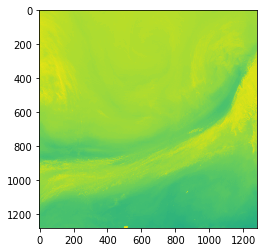

In [15]:
plt.imshow(data_var[:])
plt.show()

### Projections

The mapping will be accomplished with a combination of Cartopy and Matplotlib. To begin, we will use Cartopy’s `crs` (Coordinate Reference System) module. With the `crs`, we will create a `Globe` object that contains information about the assumed planet shape used in the projection.

In [16]:
import cartopy.crs as ccrs

# Create a Globe specifying a spherical earth with the correct radius
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.earth_radius,
                   semiminor_axis=proj_var.earth_radius)

Now that we have a globe of the appropriate shape, we need to create our projection. Knowing that that data are using the Lambert conformal conic projection, we will use the `LambertConformal` class. This class uses the globe model we just created, along with the projection information from the file, namely the central latitude, central longitude, and standard parallels.

In [17]:
proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                             central_latitude=proj_var.latitude_of_projection_origin,
                             standard_parallels=[proj_var.standard_parallel],
                             globe=globe)

### Plotting

Now that we know how to properly reference the imagery data, we can plot
the data. CartoPy's projections are designed to interface with matplotlib, so they can just be passed as the `projection` keyword argument when creating an `Axes` using the `add_subplot` method. Since the x and y coordinates, as well as the image data, are referenced in the lambert conformal projection, we can pass all of them directly to plotting methods (such as `imshow`) with no additional information. The `extent` keyword argument to `imshow` is used to specify the bounds of the image data being plotted. It is **especially important** to specify that the `origin` is at the the upper left of the image (standard practice in imagery). If your forget this, your image will be flipped. Try it!

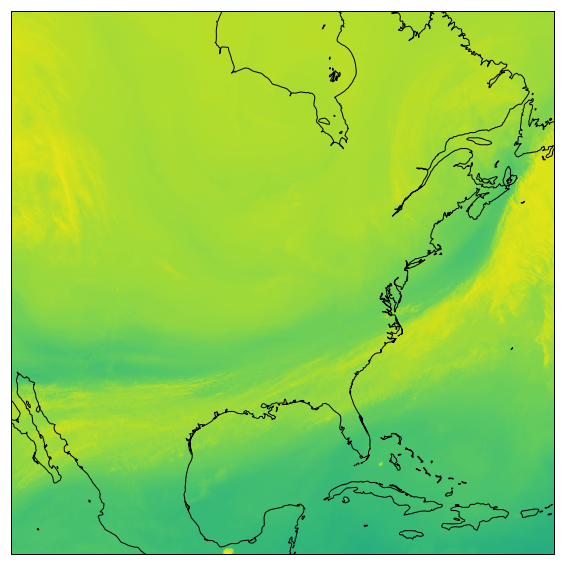

In [18]:
# Create a new figure with size 10" by 10"
fig = plt.figure(figsize=(10, 10))

# Put a single axes on this figure; set the projection for the axes to be our
# Lambert conformal projection
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the data with mostly the defaults
# Note, we save the image returned by imshow for later...
im = ax.imshow(data_var[:], extent=(x[0], x[-1], y[0], y[-1]), origin='upper')

# Add high-resolution coastlines to the plot
ax.coastlines(resolution='50m', color='black')

This is a nice start, but it would be nice to have better geographic references for the image. For example, where are the states? Cartopy's `feature` module has support for adding geographic features to plots ,with many features are built in. The `BORDERS` built-in feature contains country borders. There is also support for creating "custom" features from the [Natural Earth](http://www.naturalearthdata.com/) set of free vector and raster map data (CartoPy will automatically download the necessary data and cache it locally). Here we create a feature for states/provinces.

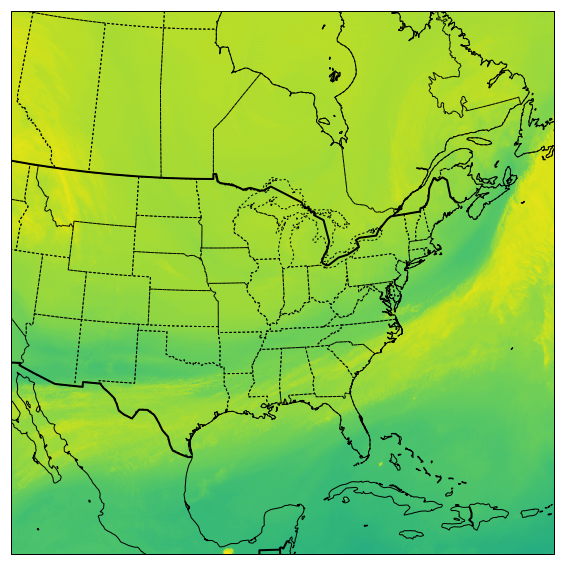

In [19]:
import cartopy.feature as cfeat

# Add country borders with a thick line.
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

# Set up a feature for the state/province lines. Tell cartopy not to fill in the polygons
state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lakes',
                                             scale='50m', facecolor='none')

# Add the feature with dotted lines, denoted by ':'
ax.add_feature(state_boundaries, linestyle=':', edgecolor='black')

# Redisplay modified figure
fig

### Exercise: Plot your data
Make a basic map of your data using what we have learned so far about plotting and adding geographic boundaries. Feel free to add features that you find interesting. Add a marker for campus, find county outlines, etc.

In [20]:
# Make a plot

<hr style="height:2px;">

## 4. Use colortables and annotations

The map is much improved now, but it would look much better with a different color scheme. 

Colormapping in matplotlib (which backs CartoPy) is handled through two pieces:

- The colormap controls how values are converted from floating point values in the range [0, 1] to colors (think colortable)
- The norm (normalization) controls how data values are converted to floating point values in the range [0, 1]

Let's start by setting the colormap to be black and white and normalizing the data to get the best contrast. As with many satellite data fields, the water vapor values range from 0-255. We clip that range down to enhance contrasts in the data. **Note:** `cmap` and `norm` can also be set during the `imshow` call as keyword arguments.

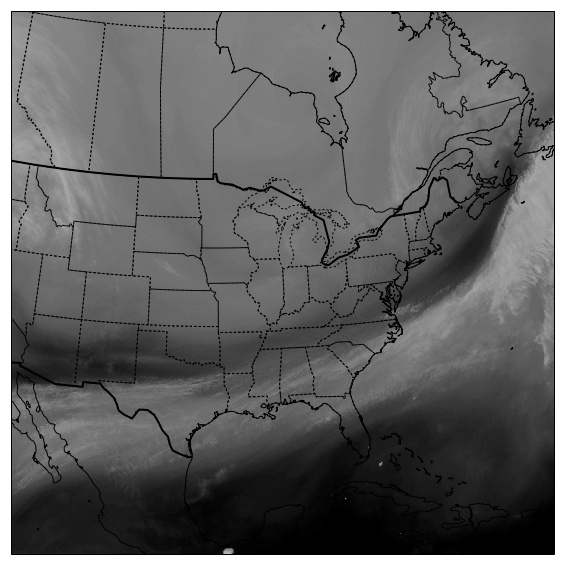

In [21]:
# Set colormap
im.set_cmap('Greys_r')

# Set norm
im.set_norm(plt.Normalize(140,255))

# Show figure again
fig

In meteorology, we have many ‘standard’ colortables that have been used for certain types of data. We have included these in Metpy in the `metpy.plots.ctables` module. By importing the `ColortableRegistry` we gain access to the colortables, as well as handy normalizations to go with them. We can see the colortables available by converting the dictionary to a list.

In [22]:
from metpy.plots.ctables import registry

print(list(registry))

['test', 'NWSStormClearReflectivity', 'wv_tpc', 'rainbow', 'NWSVelocity', 'Carbone42', 'ir_tpc', 'viridis', 'ir_drgb', 'ir_tv1', 'NWS8bitVel', 'WVCIMSS', 'NWSReflectivity', 'ir_rgbv', 'NWSReflectivityExpanded', 'NWSSpectrumWidth', 'ir_bd']


Let’s use the `WVCIMSS` colormap, a direct conversion of the GEMPAK colormap. The code below asks for the colormap, as well as a normalization that starts at 0 and increases by a value of 1 for each color in the table. We then apply it to the existing image we have been working with.

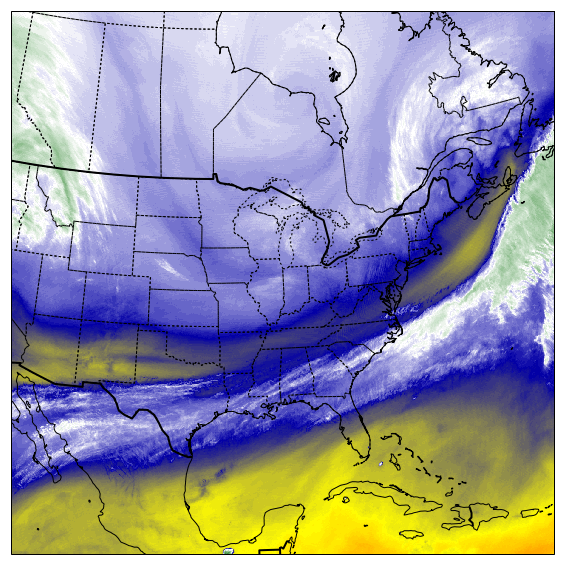

In [23]:
wv_norm, wv_cmap = registry.get_with_steps('WVCIMSS', 0, 1)

im.set_cmap(wv_cmap)
im.set_norm(wv_norm)
fig

One more thing that would be nice is putting the date and time on the image, so let's do that. First grab the `time` variable from the file:

In [24]:
time_var = gini_ds.variables['time']
print(time_var)

<class 'metpy.io.cdm.Variable'>: int32 time(time)
	units: milliseconds since 2017-03-02T00:00:00
	shape = 1


We have a variable with a single time, expressed as the number of milliseconds since a reference time. Not incredibly convenient. We could parse this manually, but the netcdf4-python package has this already covered with its `num2date` function. Remember: don’t reinvent the wheel! We just need to import `num2date` and pass it the values. We use `squeeze()` to remove any extra dimensions and units.

In [25]:
from netCDF4 import num2date
timestamp = num2date(time_var[:].squeeze(), time_var.units)
timestamp

datetime.datetime(2017, 3, 2, 20, 0, 19)

A Python `datetime` object is easy to work with. Let's add it to our plot.

We use the `text` method to draw text on our plot. In this case, we call it with a `transform` keyword argument, which allows us to tell matplotlib how to interpret the x and y coordinates. In this case, we set the transfrom to `ax.transAxes`, which means "interpret x and y as being in axes space". The axes space has x and y in the range [0, 1] across the entire plotting area (e.g. (0, 0) is lower left, (1, 1) is upper right). Using this, we can put text in the lower right corner (`x = 0.99`, `y = 0.01`) regardless of the range of x and y (or longitude and latitude) in the plot. We also need to make sure to right-align the text so that the text *ends* at the specified point.

We use the `strftime` method to format the datetime as a string. The details of that format string are described [here](https://docs.python.org/3.5/library/datetime.html#strftime-strptime-behavior).

The code below uses matplotlib's [path effects](http://matplotlib.org/users/patheffects_guide.html) to make the text have an outline effect as well. We won't go into detail on that here, but details can be found in the
[documentation](http://matplotlib.org/users/patheffects_guide.html) if you want to know more.

For completeness, the code below replicates the entirety of the plotting code from above.

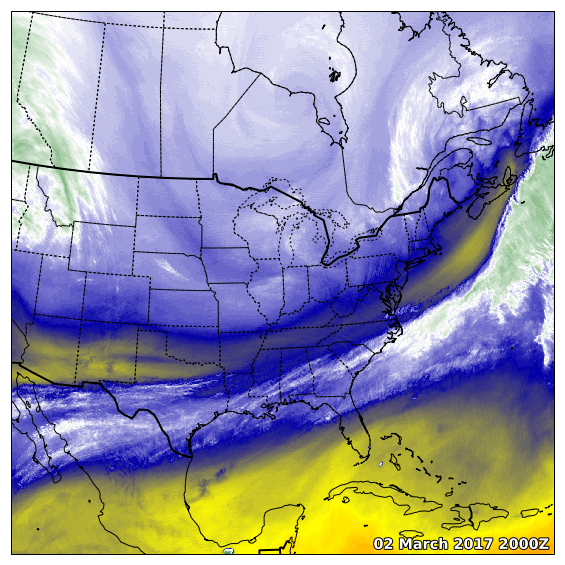

In [26]:
# Same as before, except we call imshow with our colormap and norm.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

im = ax.imshow(data_var[:], extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
               cmap=wv_cmap, norm=wv_norm)
ax.coastlines(resolution='50m', color='black')
ax.add_feature(state_boundaries, linestyle=':', edgecolor='black')
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

# Add text (aligned to the right); save the returned object so we can manipulate it.
text = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
               horizontalalignment='right', transform=ax.transAxes,
               color='white', fontsize='x-large', weight='bold')

# Make the text stand out even better using matplotlib's path effects
from matplotlib import patheffects
text.set_path_effects([patheffects.Stroke(linewidth=2, foreground='black'),
                       patheffects.Normal()])

### Exercise: Enhance your plot
Experiment with the different color maps and normalizations until you find a combination that looks nice. Add some annotations as well (date, time, satellite, resolution, etc.) Like we did above, include all of the code to make the plot this time.

In [27]:
# Your code here

<hr style="height:2px;">

## Bonus: Animations

**NOTE:**
This is just a quick taste of producing an animation using matplotlib. The animation support in matplotlib is robust, but sometimes installation of the underlying tools (mencoder/ffmpeg) can be a little tricky. In order to make sure we get don't get bogged down, this is really more of a demo than something expected to work out of the box.

For windows builds, you might try:
- For [ffmpeg](https://ffmpeg.zeranoe.com/builds/)
- For [mencoder](https://www.mplayerhq.hu/design7/dload.html)

On OSX and linux, conda-forge has packages, so it may be as easy as:

In [28]:
#!conda install -y -n unidata-workshop -c http://conda.anaconda.org/conda-forge ffmpeg

First we'll import the animation support from matplotlib. We also tell it that we want it to render the animations to HTML using the HTML5 video tag:

In [29]:
import os.path
import sys
from matplotlib import rcParams
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation

Then we create an empty figure which will serve as the basis for all of the frames of the animation:

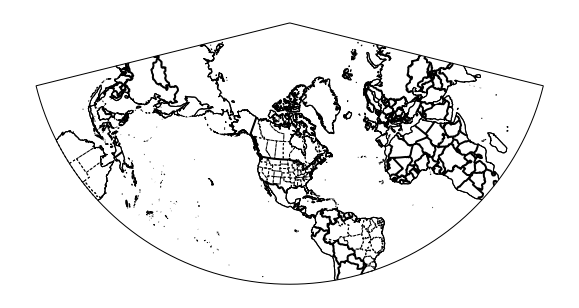

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines(zorder=2)
ax.coastlines(resolution='50m', color='black')
ax.add_feature(state_boundaries, linestyle=':', edgecolor='black')
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

Then we loop over a bunch of the datasets. For each one we pull out the data and plot both the timestamp and the image. The `ArtistAnimation` class takes the `Figure` instance and a list as required arguments. The contents of this list is a collection of matplotlib artists for each frame of the animation. In the loop below, we populate this list with the `Text` instance created when adding the timestamp as well as the image that results from plotting the data.

In [31]:
# List used to store the contents of all frames. Each item in the list is a tuple of
# (image, text)
artists = []

# Loop over the last 20 satellite images in the catalog
for ds in list(cat.datasets.values())[:-21:-1]:

    # Open the data using the HTTPServer access url and pass to GINIFile. Then convert
    # it to a netcdf-like dataset
    gini_data = GiniFile(urlopen(ds.access_urls['HTTPServer']))
    nc = gini_data.to_dataset()

    # Pull out the image data, x and y coordinates, and the time. Also go ahead and
    # convert the time to a python datetime
    x = nc.variables['x'][:]
    y = nc.variables['y'][:]
    time_var = nc.variables['time']
    timestamp = num2date(time_var[:].squeeze(), time_var.units)
    img_data = nc.variables['WV'][:]

    # Plot the image and the timestamp. We save the results of these plotting functions
    # so that we can tell the animation that these two things should be drawn as one
    # frame in the animation
    im = ax.imshow(img_data, extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
                   cmap=wv_cmap, norm=wv_norm)
    text = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
                   horizontalalignment='right', transform=ax.transAxes,
                   color='white', fontsize='x-large', weight='bold',
                   animated=True)
    
    text.set_path_effects([patheffects.Stroke(linewidth=2, foreground='black'),
                       patheffects.Normal()])

    # Stuff them in a tuple and add to the list of things to animate
    artists.append((im, text))

# Create the animation--in addition to the required args, we also state that each
# frame should last 200 milliseconds
anim = ArtistAnimation(fig, artists, interval=200.)
HTML(anim.to_html5_video())